In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np

In [2]:
base_dir = r"C:\Users\ajinf\Documents\DS 5220\Projects\SML-Project\MRNet-v1.0\train"
file_id = "0000"  

axial_path = f"{base_dir}/axial/{file_id}.npy"
coronal_path = f"{base_dir}/coronal/{file_id}.npy"
sagittal_path = f"{base_dir}/sagittal/{file_id}.npy"

axial_scan = np.load(axial_path)
coronal_scan = np.load(coronal_path)
sagittal_scan = np.load(sagittal_path)

In [3]:
axial_scan.shape, coronal_scan.shape, sagittal_scan.shape

((44, 256, 256), (36, 256, 256), (36, 256, 256))

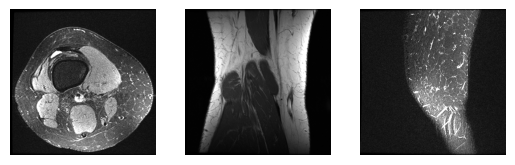

In [4]:
from matplotlib import pyplot as plt
# First slice 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for i, j in zip([ax1, ax2, ax3], [axial_scan, coronal_scan, sagittal_scan]):
    i.imshow(j[0], cmap='gray')
    i.axis(False)

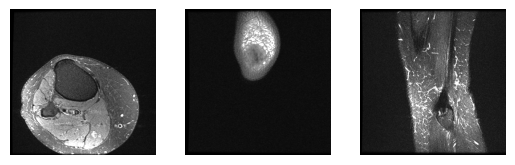

In [5]:
from matplotlib import pyplot as plt
# Last slice
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for i, j in zip([ax1, ax2, ax3], [axial_scan, coronal_scan, sagittal_scan]):
    i.imshow(j[len(j) - 1], cmap='gray')
    i.axis(False)

In [6]:
import numpy as np

def calculate_entropy(image_slice):
    histogram, _ = np.histogram(image_slice, bins=256, range=(0, 255), density=True)
    histogram = histogram + 1e-6 
    return -np.sum(histogram * np.log2(histogram))

best_slice_index_axial = np.argmax([calculate_entropy(slice) for slice in axial_scan])
best_slice_index_coronal = np.argmax([calculate_entropy(slice) for slice in coronal_scan])
best_slice_index_sagittal = np.argmax([calculate_entropy(slice) for slice in sagittal_scan])

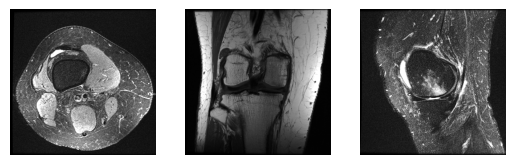

In [7]:
# Choosing the Best Slice using Entropy(Enhances the image and helps in choosing the best slice)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for i, j, z in zip([ax1, ax2, ax3], [axial_scan, coronal_scan, sagittal_scan], [best_slice_index_axial, best_slice_index_coronal, best_slice_index_sagittal]):
    i.imshow(j[z], cmap='gray')
    i.axis(False)

In [8]:
# Normalizing
axial_scan_normalize = axial_scan / 255.0
coronal_scan_normalize = coronal_scan / 255.0
sagittal_scan_normalize = sagittal_scan / 255.0

In [9]:
# Resizing
import torchvision.transforms as transforms

resize_transform = transforms.Resize((224, 224))

axial_scan_tensor = torch.tensor(axial_scan_normalize, dtype=torch.float32)  
coronal_scan_tensor = torch.tensor(coronal_scan_normalize, dtype=torch.float32)
sagittal_scan_tensor = torch.tensor(sagittal_scan_normalize, dtype=torch.float32)

axial = torch.stack([resize_transform(i.unsqueeze(0)).squeeze(0) for i in axial_scan_tensor])
coronal = torch.stack([resize_transform(i.unsqueeze(0)).squeeze(0) for i in coronal_scan_tensor])
sagittal = torch.stack([resize_transform(i.unsqueeze(0)).squeeze(0) for i in sagittal_scan_tensor])

In [10]:
import numpy as np

def calculate_entropy(image_slice):
    histogram, _ = np.histogram(image_slice, bins=256, range=(0, 255), density=True)
    histogram = histogram + 1e-6 
    return -np.sum(histogram * np.log2(histogram))

best_slice_index_axial = np.argmax([calculate_entropy(slice) for slice in axial])
best_slice_index_coronal = np.argmax([calculate_entropy(slice) for slice in coronal])
best_slice_index_sagittal = np.argmax([calculate_entropy(slice) for slice in sagittal])

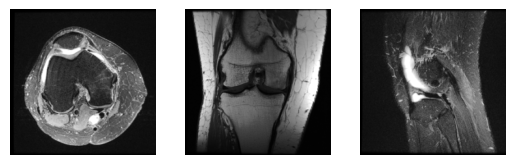

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
for i, j, z in zip([ax1, ax2, ax3], [axial, coronal, sagittal], [best_slice_index_axial, best_slice_index_coronal, best_slice_index_sagittal]):
    i.imshow(j[z], cmap='gray')
    i.axis(False)

Inspect data dimensions, file formats, and storage structure.

In [13]:
# Augmentation
from torchvision.transforms import ToPILImage

to_pil = ToPILImage()
pil_image = to_pil(axial[best_slice_index_axial])

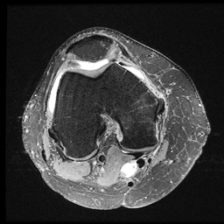

In [14]:
pil_image

In [15]:
from torchvision import transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Flip horizontally
    transforms.RandomRotation(degrees=15),   # Rotate within ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
    transforms.ToTensor()  # Convert to PyTorch tensor
])

augmented_slice = augmentation(pil_image)

# The augmented slice is now a PyTorch tensor
print(augmented_slice.shape)  # Output: torch.Size([1, H, W])

torch.Size([1, 224, 224])


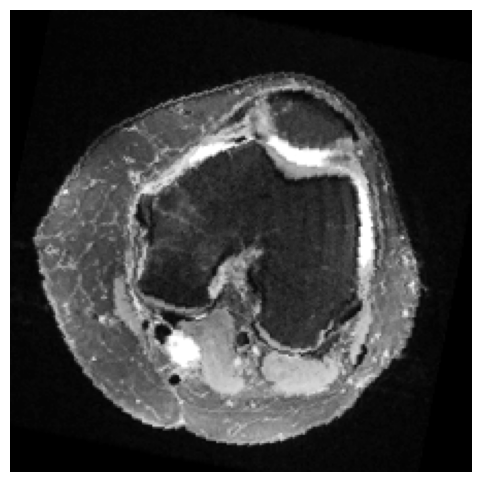

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(augmented_slice.squeeze(0), cmap='gray')  # Squeeze to remove channel dimension
plt.axis('off')
plt.show()

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [726]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import pandas as pd

def pad_or_truncate(data, target_length):
    if len(data) >= target_length:
        return data[:target_length]
    else:
        padding = np.zeros((target_length - len(data), *data.shape[1:]), dtype=data.dtype)
        return np.concatenate((data, padding), axis=0)

class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_length=20, label_dicts=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_length = target_length
        self.data_paths = []
        self.labels = []
        self.slice_counts = []
        self.label_dicts = label_dicts

        # Loop over all MRI orientations (e.g., 'axial', 'coronal', 'sagittal')
        for orientation in os.listdir(root_dir):
            orientation_path = os.path.join(root_dir, orientation)
            if os.path.isdir(orientation_path):  # Check if it's a directory (orientation folder)
                # Gather file paths and labels for each orientation
                for file_name in os.listdir(orientation_path):
                    if file_name.endswith('.npy'):
                        file_path = os.path.join(orientation_path, file_name)
                        try:
                            np_data = np.load(file_path)
                            if len(np_data) == 0:
                                print(f"Skipping empty file: {file_name}")
                                continue
                            num_slices = min(len(np_data), target_length)
                            self.data_paths.append(file_path)
                            self.slice_counts.append(num_slices)

                            # Assign labels
                            file_name_no_ext = os.path.splitext(file_name)[0]  # Remove .npy extension
                            abnormal_label = label_dicts.get('abnormal', {}).get(int(file_name_no_ext), 0)
                            acl_label = label_dicts.get('acl', {}).get(int(file_name_no_ext), 0)
                            meniscus_label = label_dicts.get('meniscus', {}).get(int(file_name_no_ext), 0)
                            self.labels.append([abnormal_label, acl_label, meniscus_label])
                        except Exception as e:
                            print(f"Error loading file {file_name}: {e}")

        self.total_slices = sum(self.slice_counts)
        print(f"Dataset initialized with {len(self.data_paths)} files, total slices: {self.total_slices}.")
        print(f"Data paths: {self.data_paths[:5]}")  # print first 5 paths
        print(f"Slice counts: {self.slice_counts[:5]}")  # print first 5 slice counts
        print(f"Labels: {self.labels[:5]}")  # print first 5 labels

    def __len__(self):
        return self.total_slices

    def __getitem__(self, idx):
        file_idx, slice_idx = self._find_file_and_slice(idx)
        file_path = self.data_paths[file_idx]
        label = self.labels[file_idx]

        np_data = np.load(file_path)
        np_data = pad_or_truncate(np_data, self.target_length)
        slice_ = np_data[slice_idx]
        transformed_slice = self.transform(Image.fromarray(slice_))

        # Return the label as a tensor
        return transformed_slice, torch.tensor(label, dtype=torch.float32)

    def _find_file_and_slice(self, idx):
        running_total = 0
        for file_idx, num_slices in enumerate(self.slice_counts):
            if running_total <= idx < running_total + num_slices:
                slice_idx = idx - running_total
                return file_idx, slice_idx
            running_total += num_slices
        raise IndexError("Index out of range")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the labels
main_dir = r"C:\Users\ajinf\Documents\DS 5220\Projects\SML-Project\MRNet-v1.0"
train_abnormal = pd.read_csv(os.path.join(main_dir, "train-abnormal.csv"), header=None, index_col=0).squeeze("columns").to_dict()
train_acl = pd.read_csv(os.path.join(main_dir, "train-acl.csv"), header=None, index_col=0).squeeze("columns").to_dict()
train_meniscus = pd.read_csv(os.path.join(main_dir, "train-meniscus.csv"), header=None, index_col=0).squeeze("columns").to_dict()

valid_abnormal = pd.read_csv(os.path.join(main_dir, "valid-abnormal.csv"), header=None, index_col=0).squeeze("columns").to_dict()
valid_acl = pd.read_csv(os.path.join(main_dir, "valid-acl.csv"), header=None, index_col=0).squeeze("columns").to_dict()
valid_meniscus = pd.read_csv(os.path.join(main_dir, "valid-meniscus.csv"), header=None, index_col=0).squeeze("columns").to_dict()

label_dicts = {
    "abnormal": train_abnormal,
    "acl": train_acl,
    "meniscus": train_meniscus
}

valid_label_dicts = {
    "abnormal": valid_abnormal,
    "acl": valid_acl,
    "meniscus": valid_meniscus
}

# Initialize datasets and dataloaders

train_dataset = MRIDataset(root_dir=os.path.join(main_dir, "train"), transform=transform, target_length=44, label_dicts=label_dicts)
val_dataset = MRIDataset(root_dir=os.path.join(main_dir, "valid"), transform=transform, target_length=44, label_dicts=valid_label_dicts)

train_subset = Subset(train_dataset, range(200))
val_subset = Subset(val_dataset, range(100))

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Debug: Inspect batch shapes
for images, labels in val_loader:
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    break

Dataset initialized with 3390 files, total slices: 106214.
Data paths: ['C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\train\\axial\\0000.npy', 'C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\train\\axial\\0001.npy', 'C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\train\\axial\\0002.npy', 'C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\train\\axial\\0003.npy', 'C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\train\\axial\\0004.npy']
Slice counts: [44, 30, 38, 33, 40]
Labels: [[1, 0, 0], [1, 1, 1], [1, 0, 0], [1, 0, 1], [1, 0, 0]]
Dataset initialized with 360 files, total slices: 11267.
Data paths: ['C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\valid\\axial\\1130.npy', 'C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNet-v1.0\\valid\\axial\\1131.npy', 'C:\\Users\\ajinf\\Documents\\DS 5220\\Projects\\SML-Project\\MRNe

In [727]:
# Total samples
total_samples = len(train_dataset.labels)

# Count positive samples for each class
count_abnormal = sum([label[0] for label in train_dataset.labels])
count_acl = sum([label[1] for label in train_dataset.labels])
count_meniscus = sum([label[2] for label in train_dataset.labels])

# Calculate weights for positive examples
weight_abnormal = total_samples / count_abnormal
weight_acl = total_samples / count_acl
weight_meniscus = total_samples / count_meniscus

# Convert to tensor for BCEWithLogitsLoss
pos_weights = torch.tensor([weight_abnormal, weight_acl, weight_meniscus], dtype=torch.float).to(device)

In [742]:
lr = 0.0001
epochs = 3
import torch.nn as nn

import torchvision.models as models

model = models.efficientnet_b4(pretrained=True)
# Unfreeze all layers of EfficientNet
for param in model.parameters():
    param.requires_grad = True
model.classifier = nn.Sequential(
    nn.Dropout(0.7),  # Dropout layer with 50% probability
    nn.Linear(model.classifier[1].in_features, 3)
)

C:\Users\ajinf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ajinf\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [744]:
import torch
import torch.optim as optim

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
    # Optimizer.
optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-3},
])
    # Loss function.
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

17,553,995 total parameters.
17,553,995 training parameters.


In [746]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss

def compute_metrics(y_true, y_pred, y_proba):
    labels = ["abnormal", "acl", "meniscus"]  # Label names for multi-label classification
    y_true_np, y_pred_np, y_proba_np = np.array(y_true), np.array(y_pred), np.array(y_proba)
    results = {}
    for i, label in enumerate(labels):
        cm = confusion_matrix(y_true_np[:, i], y_pred_np[:, i], labels=[0, 1])
        accuracy = accuracy_score(y_true_np[:, i], y_pred_np[:, i])
        precision = precision_score(y_true_np[:, i], y_pred_np[:, i], zero_division=0)
        recall = recall_score(y_true_np[:, i], y_pred_np[:, i], zero_division=0)
        f1 = f1_score(y_true_np[:, i], y_pred_np[:, i], zero_division=0)
        try:
            log_loss_value = log_loss(y_true_np[:, i], y_proba_np[:, i], labels=[0, 1])
        except ValueError as e:
            log_loss_value = None
        
        # For display
        print(f"\nMetrics for {label}:")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-Score: {f1}")
        print(f"Log Loss: {log_loss_value}")

        results[label] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'log_loss': log_loss_value
        }
    return results

In [748]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    y_true_train, y_pred_train, y_pred_proba_train = [], [], []
    
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image, labels = image, labels
        
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        
        # Calculate accuracy.
        preds = torch.sigmoid(outputs) > 0.5
        train_running_correct += (preds == labels).sum().item()

        y_true_train.extend(labels.numpy())
        y_pred_train.extend((torch.sigmoid(outputs) > 0.5).detach().numpy())
        y_pred_proba_train.extend(torch.sigmoid(outputs).detach().numpy())        
        
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()

    train_metrics = compute_metrics(np.array(y_true_train), np.array(y_pred_train), np.array(y_pred_proba_train))
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / (len(trainloader.dataset) * labels.size(1)))
    return epoch_loss, epoch_acc, train_metrics

In [750]:
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    y_true_valid, y_pred_proba_valid, y_pred_valid = [], [], []
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            image, labels = data
            image, labels = image, labels
            
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            
            # Calculate accuracy.
            preds = torch.sigmoid(outputs) > 0.5
            valid_running_correct += (preds == labels).sum().item()
            y_true_valid.extend(labels.numpy())
            y_pred_valid.extend((torch.sigmoid(outputs) > 0.5).detach().numpy())
            y_pred_proba_valid.extend(torch.sigmoid(outputs).detach().numpy())

    valid_metrics = compute_metrics(np.array(y_true_valid), y_pred_valid, np.array(y_pred_proba_valid))
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / (len(testloader.dataset) * labels.size(1)))
    return epoch_loss, epoch_acc, valid_metrics

In [752]:
from PIL import Image
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc, train_pred = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc, valid_pred = validate(model, val_loader,  
                                                criterion)
    
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)

[INFO]: Epoch 1 of 3
Training


100%|██████████| 7/7 [00:35<00:00,  5.06s/it]



Metrics for abnormal:
Confusion Matrix:
[[  0   0]
 [ 39 161]]
Accuracy: 0.805
Precision: 1.0
Recall: 0.805
F1-Score: 0.8919667590027701
Log Loss: 0.616951928790145

Metrics for acl:
Confusion Matrix:
[[113  57]
 [  7  23]]
Accuracy: 0.68
Precision: 0.2875
Recall: 0.7666666666666667
F1-Score: 0.41818181818181815
Log Loss: 0.662057758415906

Metrics for meniscus:
Confusion Matrix:
[[36 86]
 [24 54]]
Accuracy: 0.45
Precision: 0.38571428571428573
Recall: 0.6923076923076923
F1-Score: 0.4954128440366973
Log Loss: 0.7088667960989825
Validation


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]



Metrics for abnormal:
Confusion Matrix:
[[  0 100]
 [  0   0]]
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Log Loss: 1.0667924027119

Metrics for acl:
Confusion Matrix:
[[65 35]
 [ 0  0]]
Accuracy: 0.65
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Log Loss: 0.6746273567493561

Metrics for meniscus:
Confusion Matrix:
[[  0 100]
 [  0   0]]
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Log Loss: 0.8261513106923418
Training loss: 1.024, training acc: 64.500
Validation loss: 0.853, validation acc: 21.667
--------------------------------------------------
[INFO]: Epoch 2 of 3
Training


100%|██████████| 7/7 [00:34<00:00,  4.96s/it]



Metrics for abnormal:
Confusion Matrix:
[[  0   0]
 [  1 199]]
Accuracy: 0.995
Precision: 1.0
Recall: 0.995
F1-Score: 0.9974937343358395
Log Loss: 0.43354533573274395

Metrics for acl:
Confusion Matrix:
[[151  19]
 [ 13  17]]
Accuracy: 0.84
Precision: 0.4722222222222222
Recall: 0.5666666666666667
F1-Score: 0.5151515151515151
Log Loss: 0.6084684486180614

Metrics for meniscus:
Confusion Matrix:
[[ 14 108]
 [ 11  67]]
Accuracy: 0.405
Precision: 0.38285714285714284
Recall: 0.8589743589743589
F1-Score: 0.5296442687747036
Log Loss: 0.728115361820889
Validation


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]



Metrics for abnormal:
Confusion Matrix:
[[  0 100]
 [  0   0]]
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Log Loss: 1.3896094382491435

Metrics for acl:
Confusion Matrix:
[[64 36]
 [ 0  0]]
Accuracy: 0.64
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Log Loss: 0.6759643879742688

Metrics for meniscus:
Confusion Matrix:
[[  0 100]
 [  0   0]]
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Log Loss: 0.8998797033516969
Training loss: 0.915, training acc: 74.667
Validation loss: 0.992, validation acc: 21.333
--------------------------------------------------
[INFO]: Epoch 3 of 3
Training


100%|██████████| 7/7 [00:32<00:00,  4.62s/it]



Metrics for abnormal:
Confusion Matrix:
[[  0   0]
 [  1 199]]
Accuracy: 0.995
Precision: 1.0
Recall: 0.995
F1-Score: 0.9974937343358395
Log Loss: 0.3114086782883722

Metrics for acl:
Confusion Matrix:
[[152  18]
 [  7  23]]
Accuracy: 0.875
Precision: 0.5609756097560976
Recall: 0.7666666666666667
F1-Score: 0.647887323943662
Log Loss: 0.5778674596337432

Metrics for meniscus:
Confusion Matrix:
[[  6 116]
 [  2  76]]
Accuracy: 0.41
Precision: 0.3958333333333333
Recall: 0.9743589743589743
F1-Score: 0.562962962962963
Log Loss: 0.7301625291087589
Validation


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]



Metrics for abnormal:
Confusion Matrix:
[[  0 100]
 [  0   0]]
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Log Loss: 1.5337195218216522

Metrics for acl:
Confusion Matrix:
[[34 66]
 [ 0  0]]
Accuracy: 0.34
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Log Loss: 0.7200010088586134

Metrics for meniscus:
Confusion Matrix:
[[  0 100]
 [  0   0]]
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Log Loss: 0.9083727434375061
Training loss: 0.814, training acc: 76.000
Validation loss: 1.085, validation acc: 11.333
--------------------------------------------------
